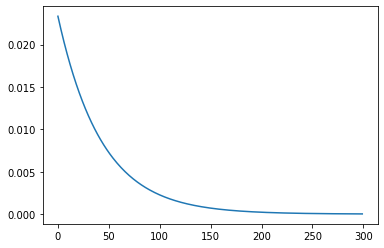

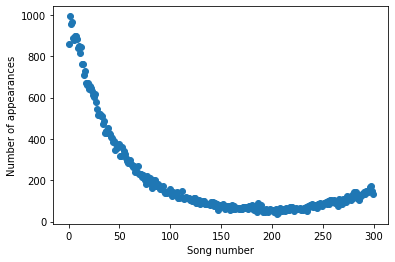

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:196: RuntimeWarning: invalid value encountered in true_divide


In [38]:
from cgi import test
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import copy
from sklearn.model_selection import train_test_split
from scipy.stats import halfnorm, expon, uniform, chi, norm
from keras import callbacks
from keras.layers import Dense, Input, Conv2D, MaxPool2D, LSTM, add
from keras.layers import Activation, Dropout, Flatten, Embedding
from keras.models import Model, Sequential
import tensorflow as tf
import scipy.stats
from IPython.display import display


def generate_items_halfnormal(amount):
    data = {}
    for i in range(amount):
        data[i] = halfnorm.pdf(i, scale=(amount/3)) 
    return data                                    

def generate_exponential(amount): #Generate a popular playlist
    data = {}
    for i in range(amount):
        data[i] = expon.pdf(i, scale=(amount/7)) 
    return data

def generate_exponential_inv(amount): #Generates a "niche" (unpopuar) playlist 
    data = {}
    for i in range(amount):
        data[amount - 1 - i] = expon.pdf(i, scale=(amount/7)) 
    return data

def generate_uniform(amount): #Generates an uniform distribution among the items
    data = {}
    for i in range(amount):
        data[i] = uniform.pdf(i, scale=amount) 
    return data

def get_cumulative_prob(y): #GETS THE CUMULATIVE PROBABIITIES OF ITEMS (IT ADDS UP TO MORE THAN 1)

    cum_prob = {}
    cum_prob[0] = y[0]

    for i in range(1, 300):
        cum_prob[i] = cum_prob[i-1] + y[i]
    return cum_prob

def get_playlists(cum_prob): #CREATES A RANDOM PLAYLLIST

    playlist = [] #empty toy playlist

    #create random playlist (like this bc they dont add to 1)
    while len(playlist) < 20:

        prob = np.random.random()
        #print(prob)
        finished = False
        i = 0
        while i < 300 and finished == False:
            if prob < cum_prob[i] and i not in playlist:
                playlist.append(i)
                finished = True
            i += 1

    playlist.sort()
    return playlist

def plot_playists_popularity(playists): #FUNCTION THAT PLOTS AL THE SONGS APPEARANCES OF ALL PLAYLISTS
    #playlists is a list of lists

    num_appearances = {} #Dictionary to store the number of times a song is in a playlist

    for playlist in playists:
        for song in playlist:
            if song in num_appearances.keys():
                num_appearances[song] += 1
            else:
                num_appearances[song] = 1

    id, counts = zip(*num_appearances.items())
    plt.scatter(id, counts)
    plt.xlabel("Song number")
    plt.ylabel("Number of appearances")
    plt.show() #BREAK POINT HERE TO SEE THE PLOT
    return num_appearances

def get_songs_ordered(songs): #RETURNS A LIST OF SONGS ORDERED BY POPULARITY (AMONG ALL THE PLAYLISTS)
    ordered_songs = []
    songs_copy = copy.deepcopy(songs)

    while songs_copy: 
        max_value = max(songs_copy, key=songs_copy.get)
        ordered_songs.append(max_value)
        songs_copy.pop(max_value)
    #print("Highest used song: ", max_value, " with ", songs_copy[max_value], " instances")
    return ordered_songs

def create_dataframe(list): #FOR NOW THE SIZE OF THE DF IS 299 AND NOT 300
    elems = []
    pred = []
    size = len(list)
    for i in range(size - 1):
        elems.append(list[i])
        pred.append(list[i + 1])
    d = {'Song':elems, 'Next':pred}
    df = pd.DataFrame(d)
    return df

def create_model():
    model = Sequential()
    input = Input(shape=(1,))
    model.add(input)
    model.add(Dense(10, activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(30, activation='tanh'))
    model.add(Dense(40, activation='tanh'))
    model.add(Dense(50, activation='tanh'))
    model.add(Dense(60, activation='tanh'))
    model.add(Dense(40, activation='tanh'))
    model.add(Dense(70, activation='tanh'))
    model.add(Dense(300, activation='sigmoid')) #model.add(Dense(1))
    return model

def create_pairs(playlists): #playlists should be a list of lists, ordered
    pairs = np.zeros((300,300))
    for playlist in playlists:
        for i in range(len(playlist)-1):
            pairs[playlist[i]][playlist[i+1]] += 1
    return pairs

def order_playists(playlists):
    for playlist in playlists:
        playlist.sort()
    return playlists

def create_training_data(pairs):
    songs = []
    next = []
    for i in range(len(pairs)):
        #max_num = 0
        songs.append(i)
        #max_num = max(pairs[i])
        pred_song = np.argmax(pairs[i])
        next.append(pred_song)
    d = {"Song":songs, "Next":next}
    df = pd.DataFrame(d)
    return df

def split_dataset(dataframe):
    X = dataframe['Song']
    y = dataframe['Next']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    train = {'Song':X_train, 'Next': y_train}
    test = {'Song':X_test, 'Next': y_test}
    return train, test

def split_dataset_prob(dataframe):
    X = dataframe['Song']
    dataframe = dataframe.drop('Song', axis=1)
    y = dataframe

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train = X
    y_train = y
    return X_train, X_test, y_train, y_test

def norm_data(data, mean, std):
    songs_norm = (data['Song'] - mean) / std
    data['Song'] = songs_norm
    return data

def get_tf_dataset(train, test):
    train_X = tf.data.Dataset.from_tensor_slices(train['Song'])
    train_Y = tf.data.Dataset.from_tensor_slices(train['Next'])

    train_dataset = tf.data.Dataset.zip((train_X, train_Y))
    train_dataset = train_dataset.shuffle(1000).batch(64)
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    test_X = tf.data.Dataset.from_tensor_slices(test['Song'])
    test_Y = tf.data.Dataset.from_tensor_slices(test['Next'])

    test_dataset = tf.data.Dataset.zip((test_X, test_Y))
    test_dataset = test_dataset.shuffle(1000).batch(64)
    test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, test_dataset

def get_probabilities(pairs):
    for num in range(len(pairs)):
        total = sum(pairs[num])
        pairs[num] /= total
    return pairs

def get_prob_dataframe(probs):
    songs = []
    next = []
    for i in range(len(probs)):
        songs.append(i)
        next.append(probs[i])
    for i in range(len(next[299])):
        next[299][i] = 0
    next[299][298] = 1
    dataframe_next = pd.DataFrame(next)
    d = {'Song': songs}
    df = pd.DataFrame(d)
    result = pd.concat([df, dataframe_next], axis=1, join='inner')
    return result

def get_nll(true_song, probs): #true_song has to be in [0,0,0...1,0] format, being the 1 in the correct song index
    nll = 0                     #probs is the output of the nn
    for i in range(len(true_song)):
        nll += true_song[i] * probs[i]
    nll = -np.log(nll)
    return nll

def get_true_song(next_songs): #expected song
    true_song = []
    item = np.argmax(next_songs)
    for i in range(len(next_songs)):
        if i == item:
            true_song.append(1)
            #print("Predicted song: ", item)
        else:
            true_song.append(0)
    return true_song

def get_nll_list(expected, idx, predictions):
    nll_list = []
    j = 0
    for i in idx:
        true_song = get_true_song(expected[i])
        nll_list.append(get_nll(true_song, predictions[j]))
        j += 1
    return nll_list

def plot_uncertainty_pop(popuarity, uncertainty):
    id, counts = zip(*popuarity.items())
    plot_dict = {}
    i = 0
    for num in counts:
        #what if its already a number
        plot_dict[num] = uncertainty[i]
        i += 1
    pop, unc = zip(*plot_dict.items())
    print(scipy.stats.pearsonr(pop, unc))
    print(scipy.stats.spearmanr(pop, unc))
    print(scipy.stats.kendalltau(pop, unc))
    plt.scatter(pop, unc)
    plt.xlabel("Popuarity")
    plt.ylabel("Uncertainty")
    plt.show() #BREAK POINT HERE TO SEE THE PLOT


data = generate_exponential(300)
#data = generate_exponential_inv(300)
#data = generate_uniform(300)
lists = sorted(data.items())
x, y = zip(*lists)
cum_prob = get_cumulative_prob(y)
playlist = get_playlists(cum_prob)
plt.plot(x, y)
plt.show() 

"""If we wanted to make 3000 playlists and the "popular" playlists are 3 times 
more popular than balanced playlists, and so on the numbers are 2076 popular, 
693 balanced, and 231 unpopular
Other option is probabilities x = 69.2307692308%; y = 23.0769230769%; z = 7.69230769231%
Other option is to randomly decide the type of the playlists"""


random.seed(1234)
playlist_list = []
data_exp = generate_exponential(300)
data_exp_inv = generate_exponential_inv(300)
data_uniform = generate_uniform(300)

data_exp = sorted(data_exp.items())
_, y_exp = zip(*data_exp)

data_exp_inv = sorted(data_exp_inv.items())
_, y_exp_inv = zip(*data_exp_inv)

data_uniform = sorted(data_uniform.items())
_, y_uni = zip(*data_uniform)

type = random.choices(population=[0,1,2], weights=[0.2307,0.6923,0.077], k=3000) #returns a list of choices

cum_prob_exp = get_cumulative_prob(y_exp) #GETS DIFFERENT PROBABIITIES
cum_prob_inv = get_cumulative_prob(y_exp_inv)
cum_prob_uni = get_cumulative_prob(y_uni)

for i in type: #GET A RANDOM PLAYLIST OF A SPECIFIC TYPE
    if i == 1:
        pl = get_playlists(cum_prob_exp)
    elif i == 2:
        pl = get_playlists(cum_prob_inv)
    else:
        pl = get_playlists(cum_prob_uni)
    playlist_list.append(pl)
popuarity = plot_playists_popularity(playlist_list) #returns the number of appearances of each song
playlists_ordered = order_playists(playlist_list)
pairs = create_pairs(playlist_list) #playlists_ordered
pairs2 = get_probabilities(pairs)
df2 = get_prob_dataframe(pairs2)

In [24]:
import argparse
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [47]:
class MLP(nn.Module):
    def __init__(self,num_input=1,num_output=1,hidden_layers=[300]):
        super().__init__()
        self.inputs = num_input
        self.outputs = num_output
        self.n_layers = len(hidden_layers)
        self.net_structure = [self.inputs,*hidden_layers,self.outputs]


        for i in range(self.n_layers+1):
            setattr(self,'layer_'+str(i), nn.Linear(self.net_structure[i], self.net_structure[i+1]))

    def forward(self,x):
        for i in range(self.n_layers):
            layer = getattr(self, 'layer_'+str(i))
            x = torch.relu(layer(x))
        layer = getattr(self,'layer_'+str(self.n_layers))
        x = layer(x)
        return x

def NLLloss(y,mean, var):
    return (torch.log(var)+ (y - mean)**2/(2*var)).sum()

In [48]:
class GaussianMLP(MLP):
    def __init__(self,num_input=1, num_output=2, hidden_layers=[300]):
        super().__init__(num_input = num_input,num_output = num_output,hidden_layers= hidden_layers)
        self.inputs = num_input
        self.outputs = num_output
    def forward(self,x):
        for i in range(self.n_layers):
            layer = getattr(self, 'layer_'+str(i))
            x = torch.relu(layer(x))
        layer = getattr(self, 'layer_' + str(self.n_layers))
        x = layer(x)
        mean, variance = torch.split(x, self.outputs-1, dim=1)
        variance = F.softplus(variance) + 1e-6 #Positive constraint
        return mean, variance

In [49]:
class GaussianMixtureMLP(nn.Module):

    def __init__(self, n_models=5, inputs=1,outputs=2, hidden_layers = [300]):
        super().__init__()
        self.n_models = n_models
        self.inputs = inputs
        self.outputs = outputs
        self.hidden_layers = hidden_layers
        for i in range(self.n_models):
            model = GaussianMLP(self.inputs,self.outputs,self.hidden_layers)
            setattr(self,'model_'+str(i),model)

    def forward(self,x):
        means = []
        variances = []
        for i in range(self.n_models):
            model = getattr(self,"model_"+str(i))
            mean, var = model(x)
            means.append(mean)
            variances.append(var)
        means = torch.stack(means)
        mean = means.mean(dim=0)
        variances = torch.stack(variances)
        var = (variances +  means.pow(2)).mean(0) - mean.pow(2)
        return mean, var

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
def generate_data(num_data=20, x_range=(-4,4), std=3.):
    x_data = [[np.random.uniform(*x_range)] for _ in range(num_data)]
    y_data = [[x[0]**3 +np.random.normal(0,std)] for x in x_data]

    return x_data ,y_data

In [51]:
  x = np.linspace(-6,6,100).reshape(100,1) # test data for regression
  x_set , y_set = generate_data() # train data for regression
  print(x_set)
  x_torch , y_torch = torch.Tensor(x_set).to(device), torch.Tensor(y_set).to(device)
  epochs = 450
  batch_size = 20
  epsilon = 0.01

[[-6.        ]
 [-5.87878788]
 [-5.75757576]
 [-5.63636364]
 [-5.51515152]
 [-5.39393939]
 [-5.27272727]
 [-5.15151515]
 [-5.03030303]
 [-4.90909091]
 [-4.78787879]
 [-4.66666667]
 [-4.54545455]
 [-4.42424242]
 [-4.3030303 ]
 [-4.18181818]
 [-4.06060606]
 [-3.93939394]
 [-3.81818182]
 [-3.6969697 ]
 [-3.57575758]
 [-3.45454545]
 [-3.33333333]
 [-3.21212121]
 [-3.09090909]
 [-2.96969697]
 [-2.84848485]
 [-2.72727273]
 [-2.60606061]
 [-2.48484848]
 [-2.36363636]
 [-2.24242424]
 [-2.12121212]
 [-2.        ]
 [-1.87878788]
 [-1.75757576]
 [-1.63636364]
 [-1.51515152]
 [-1.39393939]
 [-1.27272727]
 [-1.15151515]
 [-1.03030303]
 [-0.90909091]
 [-0.78787879]
 [-0.66666667]
 [-0.54545455]
 [-0.42424242]
 [-0.3030303 ]
 [-0.18181818]
 [-0.06060606]
 [ 0.06060606]
 [ 0.18181818]
 [ 0.3030303 ]
 [ 0.42424242]
 [ 0.54545455]
 [ 0.66666667]
 [ 0.78787879]
 [ 0.90909091]
 [ 1.03030303]
 [ 1.15151515]
 [ 1.27272727]
 [ 1.39393939]
 [ 1.51515152]
 [ 1.63636364]
 [ 1.75757576]
 [ 1.87878788]
 [ 2.     

In [42]:
X_train, X_test, y_train, y_test = split_dataset_prob(df2)

In [ ]:
X_train.to_numpy().reshape(300,1)

In [55]:
x_torch, y_torch = torch.Tensor(X_train.to_numpy().reshape(300,1)).to(device), torch.Tensor(y_train.to_numpy()).to(device)

In [20]:
def train_model_step(model, optimizer, x, y):
    """ Training an individual gaussian MLP of the deep ensemble. """
    optimizer.zero_grad()
    mean, var = model(x)
    loss = NLLloss(y, mean, var)
    loss.backward(retain_graph = True)
    data_grad = x.grad.data
    sign_grad = data_grad.sign()
    perturbed_data = x + 0.01*sign_grad
    mean_new, var_new = model(perturbed_data)
    gaussian_loss_new = NLLloss(y, mean_new, var_new)
    loss += gaussian_loss_new
    model.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [22]:
def draw_graph(x,x_set,y_set,mean_predict,std): # x-s
    #_x = np.linspace(-6,6,100)
    y = x**3
    plt.plot(x,y,'b-', label = "Ground Truth")
    plt.plot(x_set, y_set,'ro', label = 'data points')
    plt.plot(x, mean_predict, label='MLPs (MSE)', color='grey')
    plt.fill_between(x.reshape(-1), (mean_predict-3*std).reshape(100,), (mean_predict+3*std).reshape(100,),color='grey',alpha=0.3)


    plt.legend()
    plt.show()

    pass

initial loss:  [1369534.75, 42615466622976.0, 62990846001152.0, 337361057611776.0, 238850563637248.0]
final loss:  [146126159872.0, 1786167.75, 1756052.5, 1616924.0, 1605518.5]


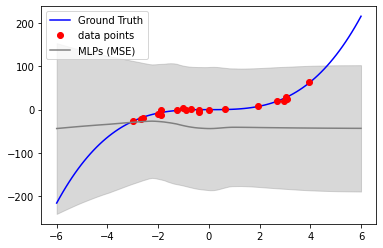

In [56]:
gmm = GaussianMixtureMLP().to(device)
gmm_optimizers = []
for i in range(gmm.n_models):
    model = getattr(gmm,'model_'+str(i))
    gmm_optimizers.append(torch.optim.Adam(model.parameters(),lr = 0.1))
x_torch.requires_grad = True
for epoch in range(epochs):
    losses =  []
    for i in range(gmm.n_models):
        model = getattr(gmm, 'model_'+str(i))
        loss = train_model_step(model,gmm_optimizers[i],x_torch, y_torch)
        losses.append(loss)
    if epoch == 0:
        print('initial loss: ', losses)

print("final loss: ", losses)
result_mean, result_var = gmm(torch.FloatTensor(x).to(device))
result_mean, result_var = result_mean.cpu().detach().numpy(), result_var.cpu().detach().numpy()
draw_graph(x,x_set,y_set,result_mean, np.sqrt(result_var))